# 🛣️ Road CIBIL Scoring Module
## Maharashtra Central Road Condition Monitoring System (CRCMS)

**Version:** 1.0.0 | **Date:** 2026-02-19  
**Methodology:** Hybrid Deterministic PDI + RandomForest Regression

---

### System Architecture

```
Dataset (16,312 highway segments)
        │
        ▼
┌─────────────────────┐
│  Phase 1: Preprocess│  ← Clean, Encode, Engineer features
└──────────┬──────────┘
           │
           ▼
┌─────────────────────┐
│  Phase 2: PDI &     │  ← Deterministic engineering formula
│  Pseudo-Labels      │    PDI = Σ(weight × normalised_distress)
└──────────┬──────────┘    Pseudo_CIBIL = 100 − PDI
           │
           ▼
┌─────────────────────┐
│  Phase 3: Train RF  │  ← RandomForestRegressor on Pseudo_CIBIL
└──────────┬──────────┘
           │
           ▼
┌─────────────────────┐
│  Phase 4: Importance│  ← Feature MDI + SHAP
└──────────┬──────────┘
           │
           ▼
┌─────────────────────┐
│  Phase 5: Hybrid    │  ← Final_CIBIL = 0.7×PDI_score + 0.3×ML
│  CIBIL Score        │
└──────────┬──────────┘
           │
           ▼
┌─────────────────────┐
│  Phase 6: Export    │  ← final_road_cibil_scores.csv
└─────────────────────┘
```

> **What is a Road CIBIL Score?**  
> Like a credit score measures financial health (300–900), the Road CIBIL Score (0–100) measures **infrastructure health**. A score of 100 means a perfectly maintained road; a score of 0 means complete structural failure requiring immediate intervention.

## Section 1 — Import Libraries & Configuration

In [1]:

# ─── Standard library ─────────────────────────────────────────────────────────
import os, warnings, logging

# ─── Data & Numerics ──────────────────────────────────────────────────────────
import numpy  as np
import pandas as pd

# ─── ML ───────────────────────────────────────────────────────────────────────
from sklearn.ensemble        import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics         import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing   import MinMaxScaler

# ─── Visualisation ────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")
log = logging.getLogger(__name__)

# ──────────────────────────────────────────────────────────────────────────────
#  GLOBAL CONFIGURATION
# ──────────────────────────────────────────────────────────────────────────────

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

BASE_DIR  = os.path.abspath("")          # notebook's working directory
DATA_PATH = os.path.join(BASE_DIR, "all_highways_segments_conditions.csv")
OUT_CSV   = os.path.join(BASE_DIR, "final_road_cibil_scores.csv")
PLOT_DIR  = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

# ── Distress columns (ordered by engineering priority) ──────────────────────
DISTRESS_COLS = [
    "iri_value",
    "alligator_cracking_pct",
    "potholes_per_km",
    "rutting_depth_mm",
    "cracks_longitudinal_pct",
    "cracks_transverse_per_km",
    "raveling_pct",
    "edge_breaking_pct",
    "patches_per_km",
    "pothole_avg_depth_cm",
]

# ── Fixed engineering ceilings for normalisation (calibrated to updated dataset) ──
# These are domain-defined upper bounds — not data-driven min-max —
# so the scale is physically meaningful and stable for future inference.
DISTRESS_MAX = {
    "iri_value"               :  9.4,   # m/km  — worst observed in updated dataset
    "alligator_cracking_pct"  : 34.2,   # % surface area
    "potholes_per_km"         : 22.0,   # count per km
    "rutting_depth_mm"        : 28.0,   # mm
    "cracks_longitudinal_pct" : 51.8,   # %
    "cracks_transverse_per_km": 25.0,   # count per km
    "raveling_pct"            : 40.2,   # %
    "edge_breaking_pct"       : 42.7,   # %
    "patches_per_km"          : 19.0,   # count per km
    "pothole_avg_depth_cm"    : 15.0,   # cm
}

# ── PDI weights (sum = 1.0) ──────────────────────────────────────────────────
PDI_WEIGHTS = {
    "iri_value"               : 0.22,   # ride quality — most rider-perceptible
    "alligator_cracking_pct"  : 0.18,   # structural fatigue failure
    "potholes_per_km"         : 0.14,   # safety hazard
    "rutting_depth_mm"        : 0.12,   # structural deformation
    "cracks_longitudinal_pct" : 0.08,   # moisture ingress risk
    "cracks_transverse_per_km": 0.07,   # thermal / load cracking
    "raveling_pct"            : 0.07,   # surface texture loss
    "edge_breaking_pct"       : 0.06,   # carriageway edge integrity
    "patches_per_km"          : 0.04,   # maintenance history proxy
    "pothole_avg_depth_cm"    : 0.02,   # severity modifier
}
assert abs(sum(PDI_WEIGHTS.values()) - 1.0) < 1e-9, "Weights must sum to 1.0"

# ── CIBIL condition bands ────────────────────────────────────────────────────
CONDITION_BINS   = [0, 40, 60, 80, 100]
CONDITION_LABELS = ["Critical", "Poor", "Fair", "Good"]

print("✅  Libraries loaded and configuration set.")
print(f"   Dataset path : {DATA_PATH}")
print(f"   Output CSV   : {OUT_CSV}")
print(f"   Plots folder : {PLOT_DIR}")
print(f"   DISTRESS_MAX updated for new dataset ✔")


✅  Libraries loaded and configuration set.
   Dataset path : /Users/sahilarundhawane/Desktop/AISSM/all_highways_segments_conditions.csv
   Output CSV   : /Users/sahilarundhawane/Desktop/AISSM/final_road_cibil_scores.csv
   Plots folder : /Users/sahilarundhawane/Desktop/AISSM/plots
   DISTRESS_MAX updated for new dataset ✔


## Section 2 — Data Loading & Initial Exploration

In [2]:
def load_dataset(path: str = DATA_PATH) -> pd.DataFrame:
    """Load the raw CSV and display a structural overview."""
    df = pd.read_csv(path)
    log.info(f"Loaded {df.shape[0]:,} rows × {df.shape[1]} columns")
    return df


# ── Load ─────────────────────────────────────────────────────────────────────
raw_df = load_dataset()

print("=" * 60)
print("  DATASET OVERVIEW")
print("=" * 60)
print(f"  Rows    : {raw_df.shape[0]:,}")
print(f"  Columns : {raw_df.shape[1]}")

print("\n── First 3 rows (distress columns only) ──")
display(raw_df[DISTRESS_COLS].head(3))

print("\n── Missing value counts (non-zero only) ──")
missing = raw_df.isnull().sum()
display(missing[missing > 0].rename("Missing Count"))

print("\n── Distress feature statistics ──")
display(raw_df[DISTRESS_COLS].describe().round(2))


INFO | Loaded 16,312 rows × 52 columns


  DATASET OVERVIEW
  Rows    : 16,312
  Columns : 52

── First 3 rows (distress columns only) ──


,iri_value,alligator_cracking_pct,potholes_per_km,rutting_depth_mm,cracks_longitudinal_pct,cracks_transverse_per_km,raveling_pct,edge_breaking_pct,patches_per_km,pothole_avg_depth_cm
0,1.8,1.7,7,0.0,11.7,4,6.1,10.7,2,0.8
1,3.4,3.0,7,13.3,14.7,1,8.3,0.1,5,2.3
2,2.7,9.1,6,11.5,11.8,7,6.8,5.7,5,2.7



── Missing value counts (non-zero only) ──


Series([], Name: Missing Count, dtype: int64)


── Distress feature statistics ──


,iri_value,alligator_cracking_pct,potholes_per_km,rutting_depth_mm,cracks_longitudinal_pct,cracks_transverse_per_km,raveling_pct,edge_breaking_pct,patches_per_km,pothole_avg_depth_cm
count,16312.00,16312.00,16312.00,16312.00,16312.00,16312.00,16312.00,16312.00,16312.00,16312.00
mean,3.87,9.90,7.11,8.71,15.85,5.90,11.09,11.92,4.76,3.97
std,1.35,5.69,4.07,4.99,9.12,3.45,6.38,6.84,2.79,2.29
min,1.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.80,5.40,4.00,4.80,8.70,3.00,6.00,6.60,3.00,2.20
50%,3.80,9.50,7.00,8.40,15.20,6.00,10.70,11.50,5.00,3.80
75%,5.00,14.50,10.00,12.80,23.20,9.00,16.30,17.40,7.00,5.80
max,9.40,34.20,22.00,28.00,51.80,25.00,40.20,42.70,19.00,15.00


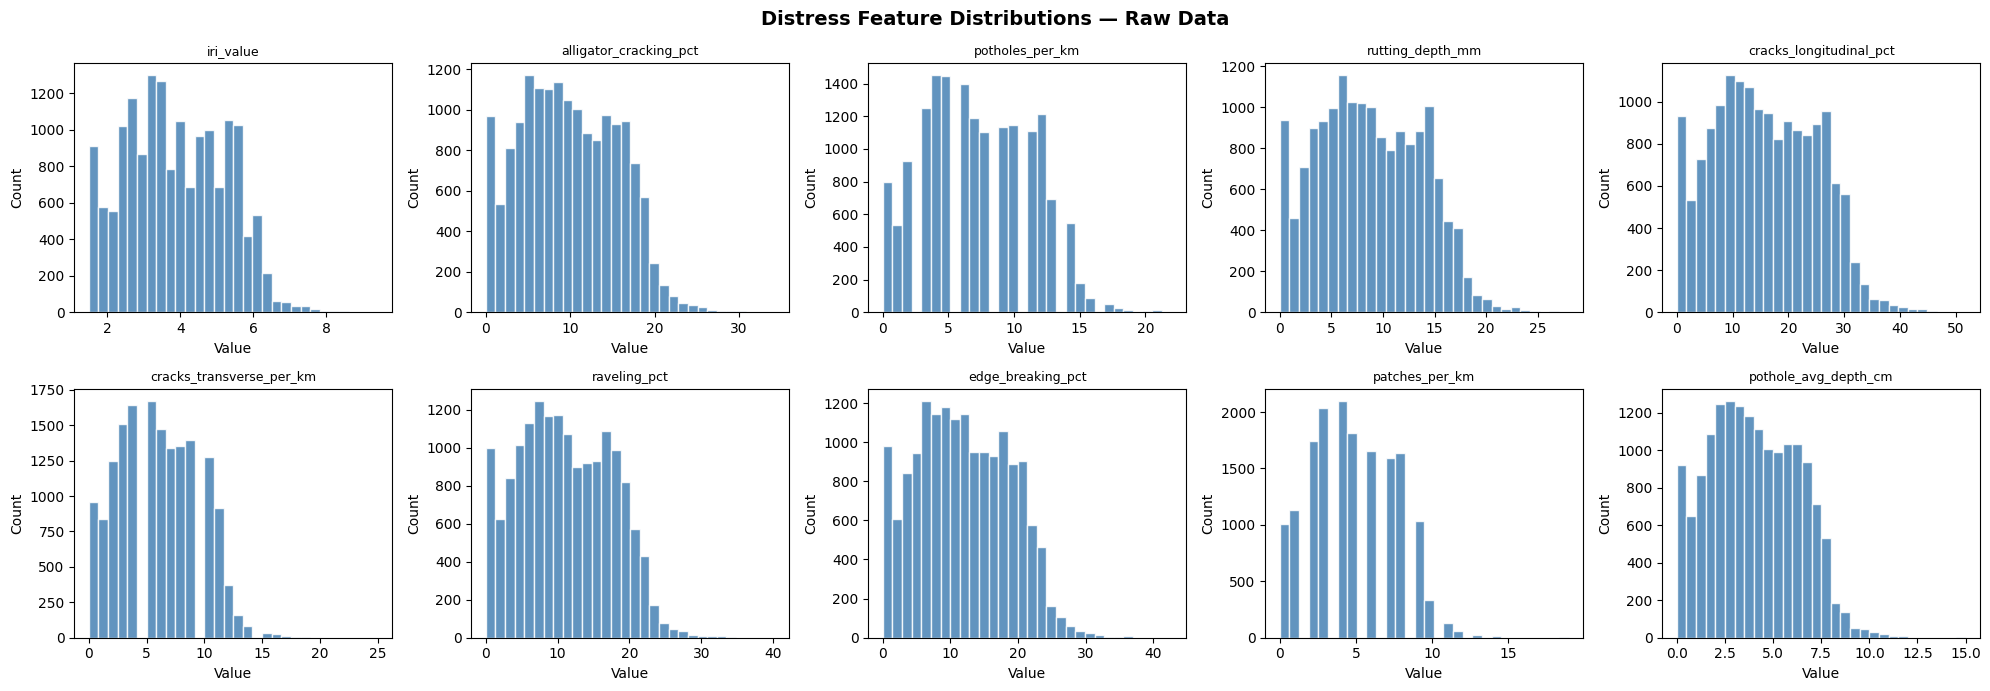

Plot saved.


In [3]:
# ── Exploratory distributions for key distress features ─────────────────────
fig, axes = plt.subplots(2, 5, figsize=(20, 7))
fig.suptitle("Distress Feature Distributions — Raw Data", fontsize=14, fontweight="bold")

for ax, col in zip(axes.flat, DISTRESS_COLS):
    ax.hist(raw_df[col].dropna(), bins=30, color="steelblue", edgecolor="white", alpha=0.85)
    ax.set_title(col, fontsize=9)
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "distress_distributions.png"), dpi=130)
plt.show()
print("Plot saved.")


## Section 3 — Data Preprocessing Pipeline

In [4]:

# ──────────────────────────────────────────────────────────────────────────────
#  3-A  MISSING VALUE HANDLING
# ──────────────────────────────────────────────────────────────────────────────

def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputation strategy:
      • Distress numerics       → median  (robust to outliers)
      • Traffic / structural    → median
      • last_major_rehab_year   → year_constructed (never rehabbed assumption)
      • Categoricals            → mode
    """
    df = df.copy()

    for col in DISTRESS_COLS:
        if col in df.columns and df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)

    numeric_fill = ["avg_daily_traffic", "truck_percentage", "peak_hour_traffic",
                    "traffic_weight", "elevation_m", "lane_count", "year_constructed"]
    for col in numeric_fill:
        if col in df.columns and df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)

    if "last_major_rehab_year" in df.columns:
        df["last_major_rehab_year"].fillna(df["year_constructed"], inplace=True)

    cat_cols = ["surface_type", "slope_category", "monsoon_rainfall_category",
                "region_type", "terrain_type"]
    for col in cat_cols:
        if col in df.columns and df[col].isnull().any():
            df[col].fillna(df[col].mode()[0], inplace=True)

    return df


# ──────────────────────────────────────────────────────────────────────────────
#  3-B  CATEGORICAL ENCODING
# ──────────────────────────────────────────────────────────────────────────────

def encode_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ordinal-encode ranked categories; one-hot-encode nominal ones.
    Boolean flags → int (0/1).
    All mappings are deterministic — no fit required, safe for inference.
    """
    df = df.copy()

    ordinal_maps = {
        "surface_type"             : {"earthen":1, "gravel":2, "bitumen":3, "concrete":4},
        "slope_category"           : {"flat":1, "moderate":2, "steep":3},
        "monsoon_rainfall_category": {"low":1, "medium":2, "high":3},
        "terrain_type"             : {"plain":1, "hilly":2, "steep":3},
    }
    for col, mapping in ordinal_maps.items():
        if col in df.columns:
            df[col] = df[col].map(mapping).fillna(2).astype(int)

    if "region_type" in df.columns:
        dummies = pd.get_dummies(df["region_type"], prefix="region", dtype=int)
        df = pd.concat([df, dummies], axis=1)
        df.drop(columns=["region_type"], inplace=True)

    for col in ["landslide_prone", "flood_prone", "ghat_section_flag", "tourism_route_flag"]:
        if col in df.columns:
            df[col] = df[col].astype(int)

    return df


# ──────────────────────────────────────────────────────────────────────────────
#  3-C  FEATURE ENGINEERING
# ──────────────────────────────────────────────────────────────────────────────

def engineer_features(df: pd.DataFrame, current_year: int = 2026) -> pd.DataFrame:
    """
    Derive time-based and traffic-load features:
      road_age          = years since construction
      years_since_rehab = years since last rehabilitation
      traffic_stress    = ADT × truck_pct / 100  (ESALs proxy)
    """
    df = df.copy()
    if "year_constructed" in df.columns:
        df["road_age"] = (current_year - df["year_constructed"]).clip(lower=0)
    if "last_major_rehab_year" in df.columns:
        df["years_since_rehab"] = (current_year - df["last_major_rehab_year"]).clip(lower=0)
    if "avg_daily_traffic" in df.columns and "truck_percentage" in df.columns:
        df["traffic_stress"] = df["avg_daily_traffic"] * df["truck_percentage"] / 100.0
    return df


# ──────────────────────────────────────────────────────────────────────────────
#  3-D  FEATURE MATRIX BUILDER
# ──────────────────────────────────────────────────────────────────────────────

_DROP_COLS = [
    "geojson_id", "highway_ref", "road_id", "name",
    "start_lat", "start_lon", "end_lat", "end_lon",
    "condition", "status", "state", "district", "taluka",
    "jurisdiction", "category", "oneway", "highway_type",
    "lanes", "maxspeed", "seasonal_variation",
    "year_constructed", "last_major_rehab_year",
    "segment_start_km", "segment_end_km", "segment_number",
    "PDI", "Pseudo_CIBIL", "ML_Predicted_CIBIL",
    "Final_CIBIL", "Condition_Category",
]

def get_feature_cols(df: pd.DataFrame) -> list:
    return [c for c in df.columns if c not in _DROP_COLS]


# ──────────────────────────────────────────────────────────────────────────────
#  3-E  FULL PREPROCESSING PIPELINE
# ──────────────────────────────────────────────────────────────────────────────

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """End-to-end preprocessing: impute → encode → engineer → return clean df."""
    df = handle_missing_values(df)
    df = encode_categoricals(df)
    df = engineer_features(df)
    return df


# ── Run ──────────────────────────────────────────────────────────────────────
clean_df = preprocess_data(raw_df.copy())
feature_cols = get_feature_cols(clean_df)

print(f"✅  Preprocessing complete.")
print(f"   Clean df    : {clean_df.shape[0]:,} rows × {clean_df.shape[1]} columns")
print(f"   Feature cols: {len(feature_cols)}")
print(f"\n   Sample feature list:\n  ", feature_cols[:15], "…")


✅  Preprocessing complete.
   Clean df    : 16,312 rows × 58 columns
   Feature cols: 33

   Sample feature list:
   ['length_km', 'lane_count', 'surface_type', 'terrain_type', 'slope_category', 'monsoon_rainfall_category', 'landslide_prone', 'flood_prone', 'ghat_section_flag', 'tourism_route_flag', 'elevation_m', 'avg_daily_traffic', 'truck_percentage', 'peak_hour_traffic', 'traffic_weight'] …


## Section 4 — Pseudo Label Generation (PDI & CIBIL)

> **Why pseudo-labels?**  
> The dataset has **no verified ground-truth condition labels**.  
> Instead of guessing, we use a **deterministic engineering formula** rooted in IRC:37 and AASHTO pavement standards to compute a Pavement Distress Index (PDI).
>
> $$PDI = \sum_{i=1}^{10} w_i \cdot \hat{x}_i \times 100 \quad \text{where } \hat{x}_i = \frac{\text{clip}(x_i, 0, \text{max}_i)}{\text{max}_i}$$
>
> $$Pseudo\_CIBIL = 100 - PDI$$

✅  Pseudo-label generation complete.

   PDI          → mean=31.76  std=13.81  min=4.6  max=83.6
   Pseudo_CIBIL → mean=68.24  std=13.81  min=16.4  max=95.4


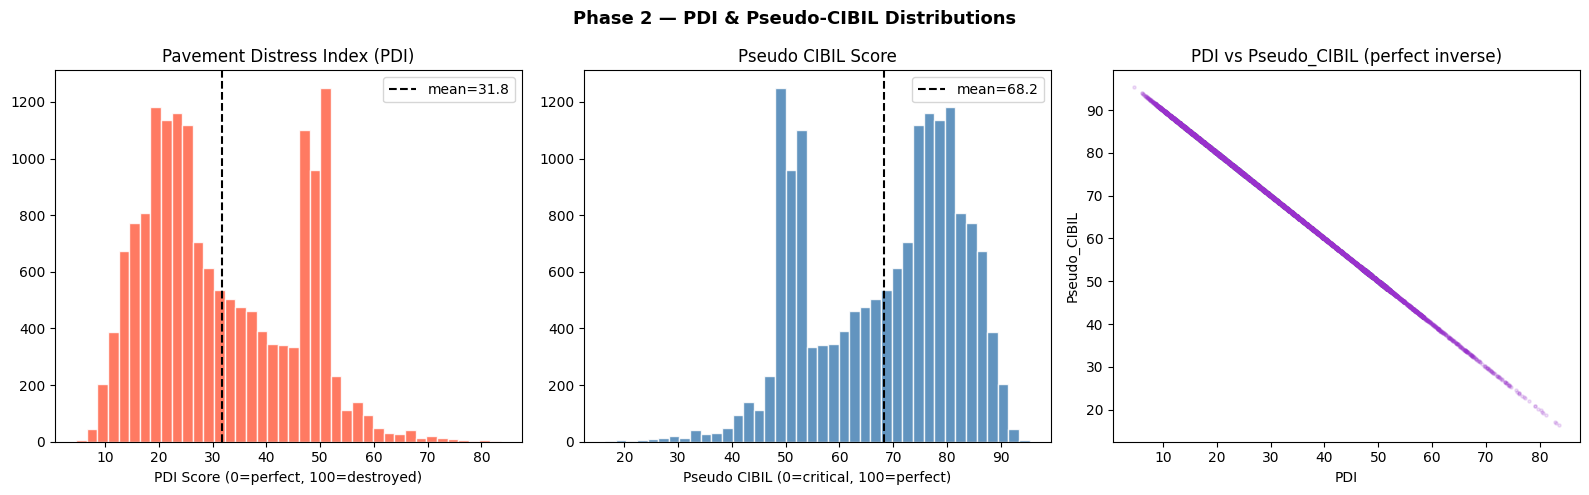

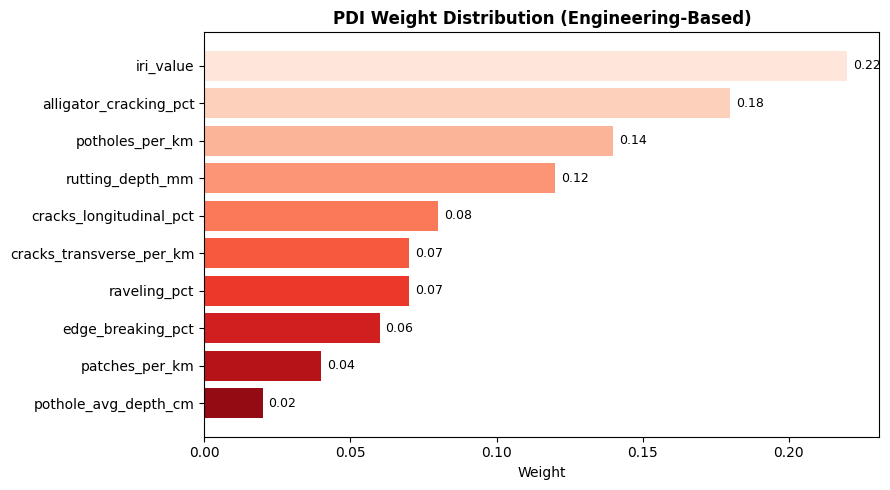

In [5]:

def _clip_normalise(series: pd.Series, max_val: float) -> pd.Series:
    """Normalise a distress series to [0,1] using a fixed engineering ceiling."""
    return (series.clip(lower=0, upper=max_val) / max_val).astype(float)


def compute_pseudo_labels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Attach PDI and Pseudo_CIBIL to the DataFrame.

    PDI weights (engineering rationale):
    ┌─────────────────────────────┬────────┬────────────────────────────────────┐
    │ Feature                     │ Weight │ Rationale                          │
    ├─────────────────────────────┼────────┼────────────────────────────────────┤
    │ IRI                         │  0.22  │ Direct ride quality, most visible  │
    │ Alligator cracking          │  0.18  │ Structural fatigue failure signal  │
    │ Potholes per km             │  0.14  │ Safety hazard, public perception   │
    │ Rutting depth               │  0.12  │ Structural deformation             │
    │ Longitudinal cracks         │  0.08  │ Moisture ingress pathway           │
    │ Transverse cracks           │  0.07  │ Thermal / load induced cracking    │
    │ Raveling                    │  0.07  │ Surface texture loss               │
    │ Edge breaking               │  0.06  │ Carriageway edge integrity         │
    │ Patches                     │  0.04  │ Maintenance history proxy          │
    │ Pothole avg depth           │  0.02  │ Severity modifier for potholes     │
    └─────────────────────────────┴────────┴────────────────────────────────────┘
    """
    df = df.copy()

    weighted_sum = pd.Series(np.zeros(len(df)), index=df.index)
    for col, weight in PDI_WEIGHTS.items():
        normalised    = _clip_normalise(df[col], DISTRESS_MAX[col])
        weighted_sum += weight * normalised

    df["PDI"]          = (weighted_sum * 100).clip(0, 100).round(2)
    df["Pseudo_CIBIL"] = (100 - df["PDI"]).clip(0, 100).round(2)

    return df


# ── Run ──────────────────────────────────────────────────────────────────────
labelled_df = compute_pseudo_labels(clean_df)

print("✅  Pseudo-label generation complete.")
print(f"\n   PDI          → mean={labelled_df['PDI'].mean():.2f}  "
      f"std={labelled_df['PDI'].std():.2f}  "
      f"min={labelled_df['PDI'].min():.1f}  max={labelled_df['PDI'].max():.1f}")
print(f"   Pseudo_CIBIL → mean={labelled_df['Pseudo_CIBIL'].mean():.2f}  "
      f"std={labelled_df['Pseudo_CIBIL'].std():.2f}  "
      f"min={labelled_df['Pseudo_CIBIL'].min():.1f}  max={labelled_df['Pseudo_CIBIL'].max():.1f}")

# ── Visualise PDI vs Pseudo_CIBIL ────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Phase 2 — PDI & Pseudo-CIBIL Distributions", fontsize=13, fontweight="bold")

axes[0].hist(labelled_df["PDI"], bins=40, color="tomato", edgecolor="white", alpha=0.85)
axes[0].set_title("Pavement Distress Index (PDI)")
axes[0].set_xlabel("PDI Score (0=perfect, 100=destroyed)")
axes[0].axvline(labelled_df["PDI"].mean(), color="black", linestyle="--",
                label=f"mean={labelled_df['PDI'].mean():.1f}")
axes[0].legend()

axes[1].hist(labelled_df["Pseudo_CIBIL"], bins=40, color="steelblue", edgecolor="white", alpha=0.85)
axes[1].set_title("Pseudo CIBIL Score")
axes[1].set_xlabel("Pseudo CIBIL (0=critical, 100=perfect)")
axes[1].axvline(labelled_df["Pseudo_CIBIL"].mean(), color="black", linestyle="--",
                label=f"mean={labelled_df['Pseudo_CIBIL'].mean():.1f}")
axes[1].legend()

axes[2].scatter(labelled_df["PDI"], labelled_df["Pseudo_CIBIL"],
                alpha=0.15, s=5, color="darkorchid")
axes[2].set_title("PDI vs Pseudo_CIBIL (perfect inverse)")
axes[2].set_xlabel("PDI"); axes[2].set_ylabel("Pseudo_CIBIL")

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "pdi_pseudo_cibil.png"), dpi=130)
plt.show()

# ── Weight contribution bar chart ────────────────────────────────────────────
fig2, ax2 = plt.subplots(figsize=(9, 5))
feat_names = list(PDI_WEIGHTS.keys())
weights    = list(PDI_WEIGHTS.values())
colors     = sns.color_palette("Reds_r", len(weights))
ax2.barh(feat_names[::-1], weights[::-1], color=colors)
ax2.set_title("PDI Weight Distribution (Engineering-Based)", fontsize=12, fontweight="bold")
ax2.set_xlabel("Weight")
for i, (w, n) in enumerate(zip(weights[::-1], feat_names[::-1])):
    ax2.text(w + 0.002, i, f"{w:.2f}", va="center", fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "pdi_weights.png"), dpi=130)
plt.show()


## Section 5 — Supervised Regression Model Training

In [6]:

def train_model(
    df: pd.DataFrame,
    feature_cols: list,
    target: str = "Pseudo_CIBIL",
    test_size: float = 0.20,
    random_state: int = RANDOM_SEED,
):
    """
    Train a RandomForestRegressor on (features → Pseudo_CIBIL).

    Pipeline:
      1. MinMaxScaler on X (keeps numeric ranges consistent)
      2. 80/20 stratification-free split
      3. RF with sensible production defaults

    Returns: model, scaler, X_test_scaled, y_test, y_pred, feature_cols
    """
    X = df[feature_cols].copy()
    y = df[target].copy()

    # Scale
    scaler   = MinMaxScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=feature_cols, index=X.index,
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state,
    )

    model = RandomForestRegressor(
        n_estimators  = 200,
        max_depth     = 15,
        min_samples_leaf = 4,
        n_jobs        = -1,
        random_state  = random_state,
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Attach scaler for later inference
    model._scaler       = scaler
    model._feature_cols = feature_cols

    return model, scaler, X_test, y_test, y_pred


# ── Run ──────────────────────────────────────────────────────────────────────
feature_cols = get_feature_cols(labelled_df)

model, scaler, X_test, y_test, y_pred = train_model(labelled_df, feature_cols)

print(f"✅  Model trained on {len(labelled_df) - len(y_test):,} samples  "
      f"| tested on {len(y_test):,} samples")
print(f"   Features used : {len(feature_cols)}")
print(f"   Estimators    : {model.n_estimators}")
print(f"   Max depth     : {model.max_depth}")


✅  Model trained on 13,049 samples  | tested on 3,263 samples
   Features used : 33
   Estimators    : 200
   Max depth     : 15


## Section 6 — Model Evaluation

  MODEL EVALUATION — TEST SET
  Metric          Value
--------------------------------------------------
  MAE            0.3400
  RMSE           0.4832
  R²             0.9988


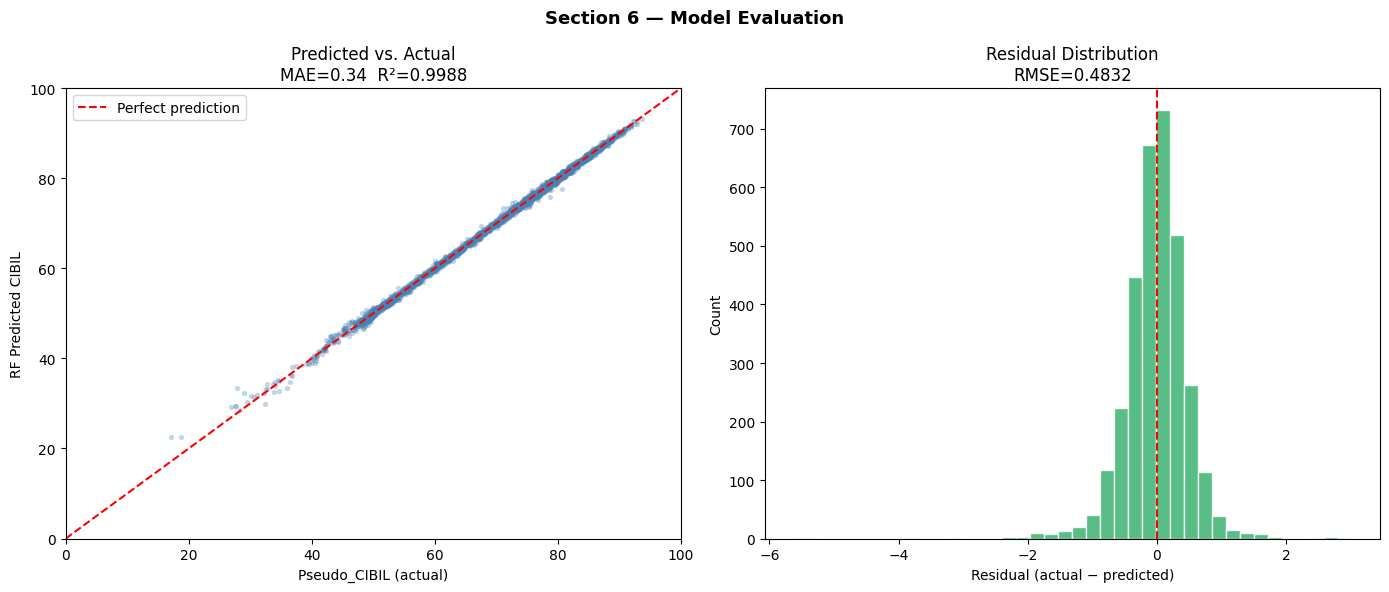

In [7]:

def evaluate_model(y_true, y_pred) -> dict:
    """Compute and return MAE, RMSE, and R² metrics."""
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return {"MAE": round(mae, 4), "RMSE": round(rmse, 4), "R²": round(r2, 4)}


metrics = evaluate_model(y_test, y_pred)

print("=" * 50)
print("  MODEL EVALUATION — TEST SET")
print("=" * 50)
print(f"  {'Metric':<10} {'Value':>10}")
print("-" * 50)
for k, v in metrics.items():
    print(f"  {k:<10} {v:>10.4f}")
print("=" * 50)

# ── Predicted vs. Actual scatter ─────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Section 6 — Model Evaluation", fontsize=13, fontweight="bold")

# Scatter
axes[0].scatter(y_test, y_pred, alpha=0.25, s=8, color="steelblue")
axes[0].plot([0, 100], [0, 100], "r--", linewidth=1.5, label="Perfect prediction")
axes[0].set_xlabel("Pseudo_CIBIL (actual)")
axes[0].set_ylabel("RF Predicted CIBIL")
axes[0].set_title(f"Predicted vs. Actual\nMAE={metrics['MAE']}  R²={metrics['R²']}")
axes[0].set_xlim(0, 100); axes[0].set_ylim(0, 100)
axes[0].legend()

# Residuals
residuals = np.array(y_test) - np.array(y_pred)
axes[1].hist(residuals, bins=40, color="mediumseagreen", edgecolor="white", alpha=0.85)
axes[1].axvline(0, color="red", linestyle="--", linewidth=1.5)
axes[1].set_title(f"Residual Distribution\nRMSE={metrics['RMSE']}")
axes[1].set_xlabel("Residual (actual − predicted)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "model_evaluation.png"), dpi=130)
plt.show()


## Section 7 — Feature Importance & SHAP Analysis

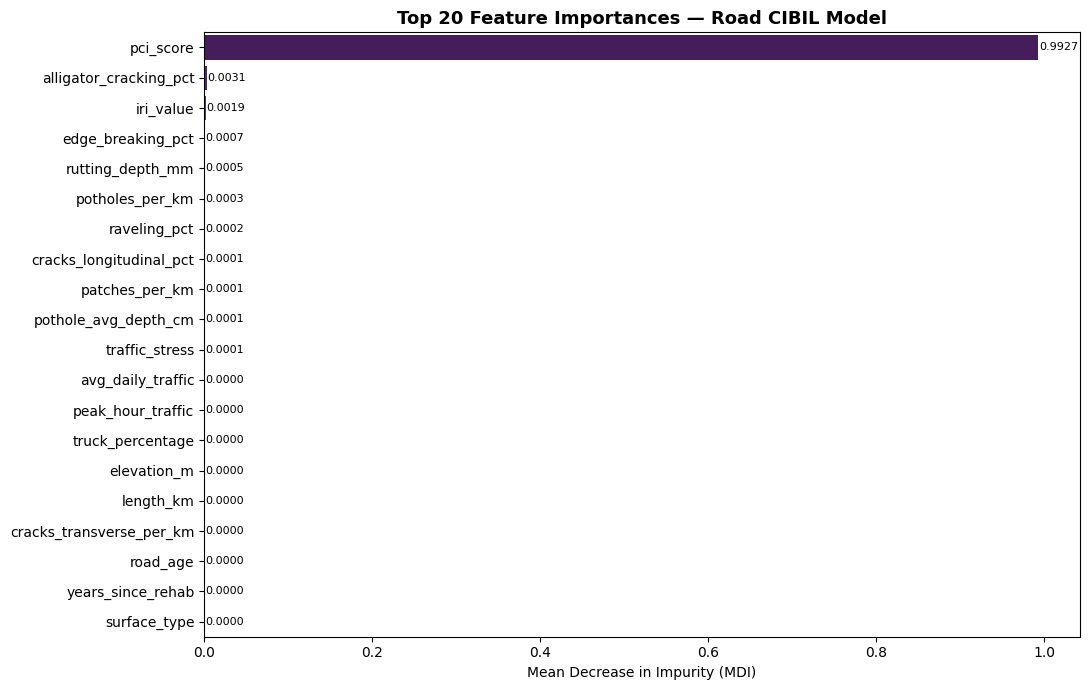


   Top 10 most important features:


,feature,importance
0,pci_score,0.992716
1,alligator_cracking_pct,0.003064
2,iri_value,0.001874
3,edge_breaking_pct,0.000660
4,rutting_depth_mm,0.000487
5,potholes_per_km,0.000328
6,raveling_pct,0.000161
7,cracks_longitudinal_pct,0.000147
8,patches_per_km,0.000091
9,pothole_avg_depth_cm,0.000077


In [8]:

def plot_feature_importance(model, feature_cols: list, top_n: int = 20) -> pd.DataFrame:
    """
    Extract and plot top-N most important features by mean impurity decrease (MDI).
    Returns ranked DataFrame.
    """
    importance_df = pd.DataFrame({
        "feature"   : feature_cols,
        "importance": model.feature_importances_,
    }).sort_values("importance", ascending=False).reset_index(drop=True)

    top_df = importance_df.head(top_n)

    fig, ax = plt.subplots(figsize=(11, 7))
    palette = sns.color_palette("viridis", top_n)
    sns.barplot(data=top_df, x="importance", y="feature", palette=palette, ax=ax)
    ax.set_title(f"Top {top_n} Feature Importances — Road CIBIL Model",
                 fontsize=13, fontweight="bold")
    ax.set_xlabel("Mean Decrease in Impurity (MDI)")
    ax.set_ylabel("")
    for i, row in top_df.iterrows():
        ax.text(row["importance"] + 0.001, i, f"{row['importance']:.4f}",
                va="center", fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "feature_importance.png"), dpi=130)
    plt.show()
    return importance_df


importance_df = plot_feature_importance(model, feature_cols, top_n=20)

print("\n   Top 10 most important features:")
display(importance_df.head(10))


  Computing SHAP values on a random sample of roads…


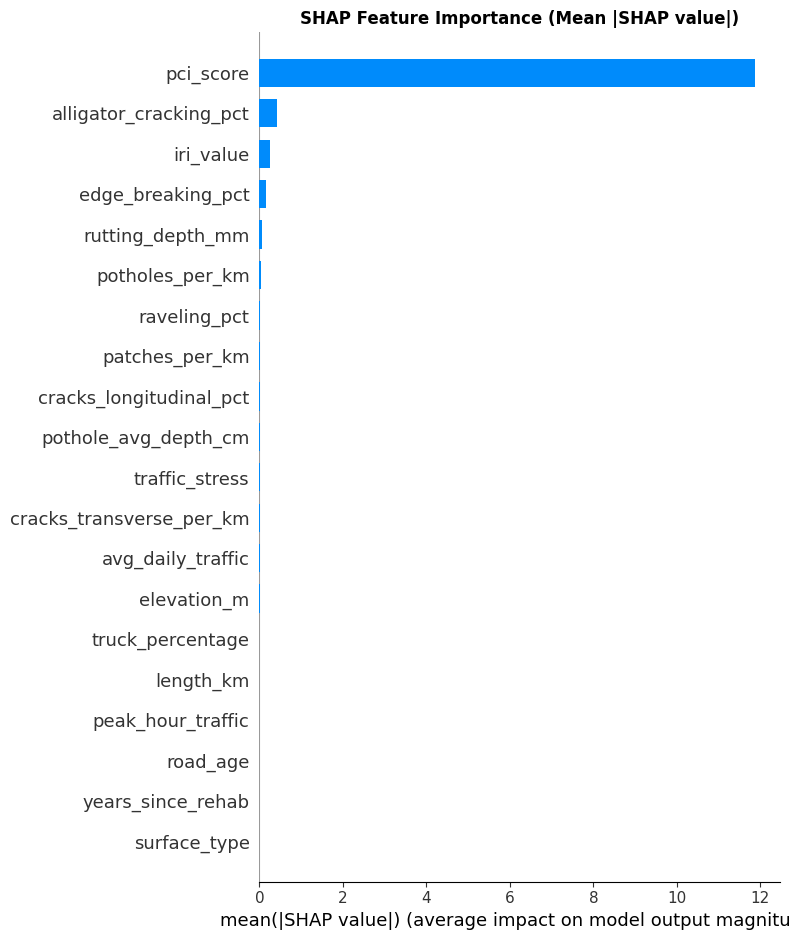

  ✅  SHAP plot saved.


In [9]:

def run_shap_analysis(model, df: pd.DataFrame, feature_cols: list,
                      sample_n: int = 600) -> None:
    """
    Compute SHAP TreeExplainer values and render a summary bar plot.
    Gracefully skips if SHAP is unavailable or raises an error.
    """
    try:
        import shap
        print("  Computing SHAP values on a random sample of roads…")
        X = df[feature_cols].copy()
        X_scaled = pd.DataFrame(
            model._scaler.transform(X),
            columns=feature_cols, index=X.index,
        )
        sample      = X_scaled.sample(n=min(sample_n, len(X_scaled)), random_state=42)
        explainer   = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(sample)

        fig, ax = plt.subplots(figsize=(11, 8))
        shap.summary_plot(shap_values, sample, show=False, plot_type="bar")
        plt.title("SHAP Feature Importance (Mean |SHAP value|)",
                  fontsize=12, fontweight="bold")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, "shap_summary.png"),
                    dpi=130, bbox_inches="tight")
        plt.show()
        print("  ✅  SHAP plot saved.")

    except ImportError:
        print("  ⚠️  SHAP not installed — skipping. Run: pip install shap")
    except Exception as e:
        print(f"  ⚠️  SHAP computation failed: {e}")


run_shap_analysis(model, labelled_df, feature_cols)


## Section 8 — Hybrid CIBIL Score Computation

> **Hybrid Blending Formula:**
>
> $$Final\_CIBIL = 0.7 \times Pseudo\_CIBIL + 0.3 \times ML\_Predicted\_CIBIL$$
>
> | Component | Weight | Rationale |
> |---|---|---|
> | Pseudo_CIBIL (PDI-based) | **70%** | Engineering transparency, governance auditability |
> | ML_Predicted_CIBIL | **30%** | Nonlinear refinement using traffic, age, environment |
>
> **Condition Bands:**
>
> | Score Range | Category | Action |
> |---|---|---|
> | 80 – 100 | 🟢 Good | Routine maintenance |
> | 60 – 79 | 🟡 Fair | Preventive treatment within 1 year |
> | 40 – 59 | 🟠 Poor | Rehabilitation required urgently |
> | 0 – 39 | 🔴 Critical | Immediate intervention required |

In [10]:

def compute_hybrid_cibil(
    df: pd.DataFrame,
    model,
    feature_cols: list,
    pseudo_weight: float = 0.7,
    ml_weight: float = 0.3,
) -> pd.DataFrame:
    """
    1. Predict ML_Predicted_CIBIL = model.predict(X_full_scaled)
    2. Blend: Final_CIBIL = pseudo_weight×Pseudo_CIBIL + ml_weight×ML_Predicted_CIBIL
    3. Assign Condition_Category via pd.cut
    """
    assert abs(pseudo_weight + ml_weight - 1.0) < 1e-9, "Weights must sum to 1.0"

    df = df.copy()

    # Full-dataset inference
    X_full = df[feature_cols].copy()
    X_scaled = pd.DataFrame(
        model._scaler.transform(X_full),
        columns=feature_cols, index=X_full.index,
    )
    df["ML_Predicted_CIBIL"] = np.clip(model.predict(X_scaled), 0, 100).round(2)

    # Blend
    df["Final_CIBIL"] = (
        pseudo_weight * df["Pseudo_CIBIL"]
        + ml_weight   * df["ML_Predicted_CIBIL"]
    ).clip(0, 100).round(2)

    # Condition bands
    df["Condition_Category"] = pd.cut(
        df["Final_CIBIL"],
        bins=CONDITION_BINS,
        labels=CONDITION_LABELS,
        include_lowest=True,
    ).astype(str)

    return df


# ── Run ──────────────────────────────────────────────────────────────────────
scored_df = compute_hybrid_cibil(labelled_df, model, feature_cols)

print("✅  Hybrid CIBIL scoring complete.")
print(f"\n   ML_Predicted_CIBIL → mean={scored_df['ML_Predicted_CIBIL'].mean():.2f}  "
      f"std={scored_df['ML_Predicted_CIBIL'].std():.2f}")
print(f"   Final_CIBIL        → mean={scored_df['Final_CIBIL'].mean():.2f}  "
      f"std={scored_df['Final_CIBIL'].std():.2f}")
print(f"\n   Condition distribution:")
print(scored_df["Condition_Category"].value_counts().to_string())


✅  Hybrid CIBIL scoring complete.

   ML_Predicted_CIBIL → mean=68.24  std=13.79
   Final_CIBIL        → mean=68.24  std=13.80

   Condition distribution:
Condition_Category
Fair        7390
Poor        4937
Good        3764
Critical     221


## Section 9 — Output Module & Export

In [11]:

def export_results(scored_df: pd.DataFrame, out_path: str = OUT_CSV) -> pd.DataFrame:
    """
    Assemble and export the final Road CIBIL output CSV.

    Output columns (road identifier + 5 scoring columns):
      road_id, name, segment_number, district, taluka, length_km,
      PDI, Pseudo_CIBIL, ML_Predicted_CIBIL, Final_CIBIL, Condition_Category

    Sorted descending by Final_CIBIL.
    """
    id_cols = [c for c in [
        "road_id", "name", "geojson_id", "highway_ref",
        "segment_number", "segment_start_km", "segment_end_km",
        "length_km", "district", "taluka",
    ] if c in scored_df.columns]

    score_cols = ["PDI", "Pseudo_CIBIL", "ML_Predicted_CIBIL",
                  "Final_CIBIL", "Condition_Category"]

    output_df = (
        scored_df[id_cols + score_cols]
        .sort_values("Final_CIBIL", ascending=False)
        .reset_index(drop=True)
    )
    output_df.to_csv(out_path, index=False)
    print(f"  ✅  Exported → {out_path}")
    return output_df


output_df = export_results(scored_df)

print(f"\n  Output shape: {output_df.shape[0]:,} rows × {output_df.shape[1]} columns")
print("\n── Top 10 roads (highest CIBIL score) ──")
display(output_df.head(10))

print("\n── Bottom 10 roads (most critical) ──")
display(output_df.tail(10))


  ✅  Exported → /Users/sahilarundhawane/Desktop/AISSM/final_road_cibil_scores.csv

  Output shape: 16,312 rows × 15 columns

── Top 10 roads (highest CIBIL score) ──


,road_id,name,geojson_id,highway_ref,segment_number,segment_start_km,segment_end_km,length_km,district,taluka,PDI,Pseudo_CIBIL,ML_Predicted_CIBIL,Final_CIBIL,Condition_Category
0,MA-NH53-SEG-0415,NH53 Segment 415,way/873993041,NH53,415,79.3,93.9,14.6,Solapur,Madha,4.64,95.36,93.71,94.86,Good
1,MA-NH60-SEG-0528,NH60 Segment 528,way/1030328546,NH60,528,158.4,167.0,8.6,Solapur,Karmala,6.09,93.91,93.67,93.84,Good
2,MA-NH66-SEG-0512,NH66 Segment 512,way/1353326662,NH66,512,193.4,198.9,5.5,Solapur,Sangola,6.10,93.90,93.46,93.77,Good
3,MA-NH53-SEG-0544,NH53 Segment 544,way/885782724,NH53,544,106.0,127.3,21.3,Pune,Ambegaon,6.33,93.67,93.37,93.58,Good
4,MA-NH66-SEG-0307,NH66 Segment 307,way/1192749921,NH66,307,71.3,96.2,24.9,Dhule,Shirpur,6.30,93.70,93.13,93.53,Good
5,MA-NH53-SEG-0001,NH53 Segment 1,way/22830633,NH53,1,48.1,65.4,17.3,Raigad,Poladpur,6.61,93.39,93.45,93.41,Good
6,MA-NH166-SEG-0110,NH166 Segment 110,way/695634279,NH166,110,47.3,61.5,14.2,Solapur,Madha,6.49,93.51,92.95,93.34,Good
7,MA-NH753A-SEG-0079,NH753A Segment 79,way/499279929,NH753A,79,104.2,123.9,19.7,Dhule,Dhule,6.68,93.32,93.06,93.24,Good
8,MA-NH60-SEG-0124,NH60 Segment 124,way/216957620,NH60,124,106.8,115.5,8.7,Solapur,Sangola,6.79,93.21,93.14,93.19,Good
9,MA-NH66-SEG-0173,NH66 Segment 173,way/941384539,NH66,173,170.8,191.0,20.2,Dhule,Sindkhede,6.79,93.21,93.01,93.15,Good



── Bottom 10 roads (most critical) ──


,road_id,name,geojson_id,highway_ref,segment_number,segment_start_km,segment_end_km,length_km,district,taluka,PDI,Pseudo_CIBIL,ML_Predicted_CIBIL,Final_CIBIL,Condition_Category
16302,MA-NH353J-SEG-0070,NH353J Segment 70,way/867604103,NH353J,70,78.5,87.1,8.6,Sindhudurg,Malvan,79.10,20.90,22.99,21.53,Critical
16303,MA-NH48-SEG-1075,NH48 Segment 1075,way/1271406693,NH48,1075,114.5,128.3,13.8,Kolhapur,Ajra,79.12,20.88,21.95,21.20,Critical
16304,MA-NH53-SEG-0061,NH53 Segment 61,way/217394249,NH53,61,129.7,149.4,19.7,Kolhapur,Ajra,79.77,20.23,21.64,20.65,Critical
16305,MA-NH44-SEG-0053,NH44 Segment 53,way/182450913,NH44,53,129.1,143.0,13.9,Kolhapur,Bhudargad,80.47,19.53,22.43,20.40,Critical
16306,MA-NH548D-SEG-0079,NH548D Segment 79,way/298681372,NH548D,79,95.1,102.8,7.7,Kolhapur,Shirol,80.20,19.80,21.32,20.26,Critical
16307,MA-NH548E-SEG-0008,NH548E Segment 8,way/305190712,NH548E,8,93.6,113.7,20.1,Sindhudurg,Vaibhavwadi,81.26,18.74,22.57,19.89,Critical
16308,MA-NH166-SEG-0489,NH166 Segment 489,way/1257443663,NH166,489,43.9,65.5,21.6,Raigad,Shrivardhan,80.68,19.32,20.75,19.75,Critical
16309,MA-NH361-SEG-0415,NH361 Segment 415,way/979868816,NH361,415,113.2,136.6,23.4,Raigad,Mahad,83.05,16.95,24.29,19.15,Critical
16310,MA-NH160-SEG-0182,NH160 Segment 182,way/753658401,NH160,182,68.0,80.1,12.1,Kolhapur,Karveer,82.80,17.20,22.51,18.79,Critical
16311,MA-NH753J-SEG-0047,NH753J Segment 47,way/298884647,NH753J,47,27.8,44.9,17.1,Kolhapur,Bavda,83.56,16.44,20.06,17.53,Critical


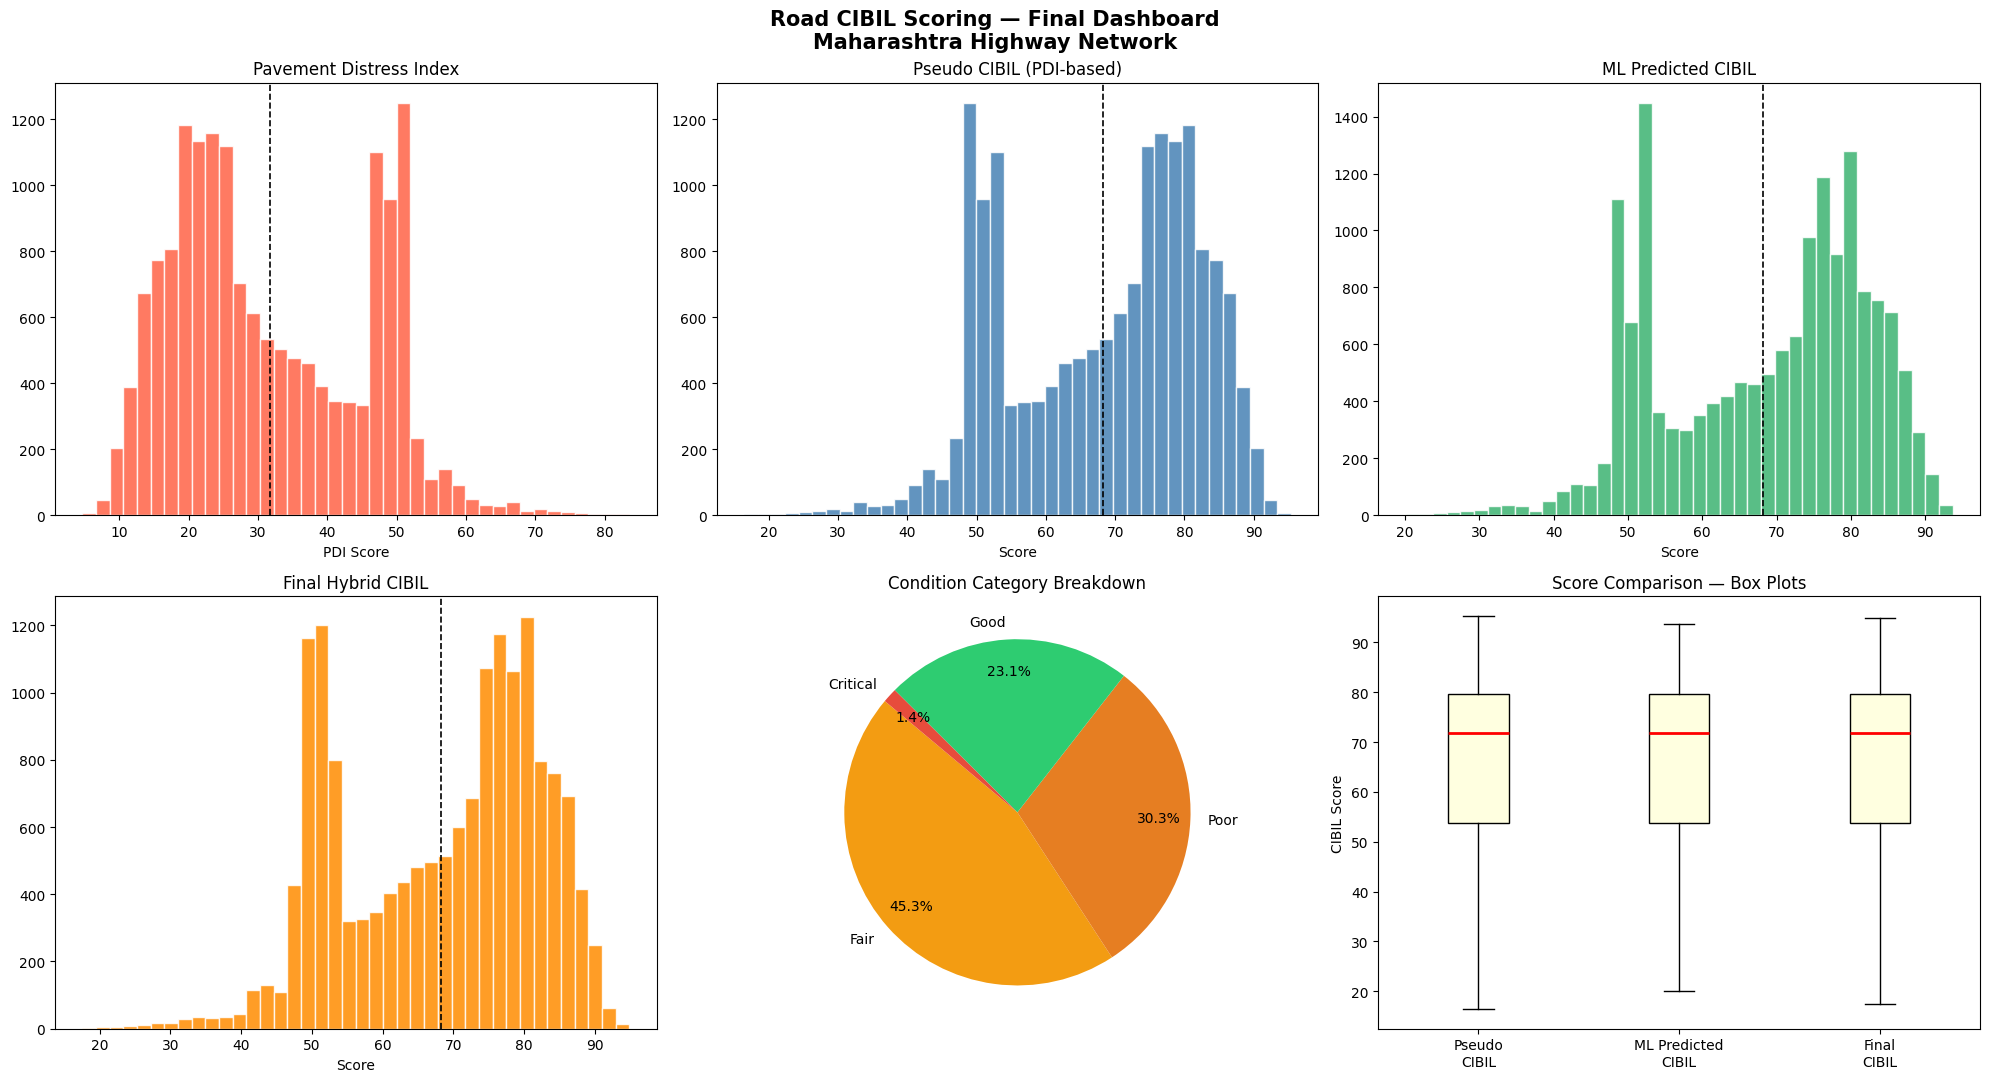

📊  Dashboard saved.


In [12]:

# ── Final visualisation dashboard ─────────────────────────────────────────────

fig, axes = plt.subplots(2, 3, figsize=(20, 11))
fig.suptitle("Road CIBIL Scoring — Final Dashboard\nMaharashtra Highway Network",
             fontsize=15, fontweight="bold")

# 1. PDI histogram
axes[0, 0].hist(scored_df["PDI"], bins=40, color="tomato", edgecolor="white", alpha=0.85)
axes[0, 0].axvline(scored_df["PDI"].mean(), color="black", linestyle="--", linewidth=1.2)
axes[0, 0].set_title("Pavement Distress Index")
axes[0, 0].set_xlabel("PDI Score")

# 2. Pseudo_CIBIL histogram
axes[0, 1].hist(scored_df["Pseudo_CIBIL"], bins=40, color="steelblue", edgecolor="white", alpha=0.85)
axes[0, 1].axvline(scored_df["Pseudo_CIBIL"].mean(), color="black", linestyle="--", linewidth=1.2)
axes[0, 1].set_title("Pseudo CIBIL (PDI-based)")
axes[0, 1].set_xlabel("Score")

# 3. ML Predicted CIBIL histogram
axes[0, 2].hist(scored_df["ML_Predicted_CIBIL"], bins=40, color="mediumseagreen",
                edgecolor="white", alpha=0.85)
axes[0, 2].axvline(scored_df["ML_Predicted_CIBIL"].mean(), color="black", linestyle="--", linewidth=1.2)
axes[0, 2].set_title("ML Predicted CIBIL")
axes[0, 2].set_xlabel("Score")

# 4. Final CIBIL histogram
axes[1, 0].hist(scored_df["Final_CIBIL"], bins=40, color="darkorange", edgecolor="white", alpha=0.85)
axes[1, 0].axvline(scored_df["Final_CIBIL"].mean(), color="black", linestyle="--", linewidth=1.2)
axes[1, 0].set_title("Final Hybrid CIBIL")
axes[1, 0].set_xlabel("Score")

# 5. Condition category pie
category_counts = scored_df["Condition_Category"].value_counts()
COLORS = {"Good": "#2ecc71", "Fair": "#f39c12", "Poor": "#e67e22", "Critical": "#e74c3c"}
pie_colors = [COLORS.get(c, "#bdc3c7") for c in category_counts.index]
axes[1, 1].pie(category_counts.values, labels=category_counts.index,
               colors=pie_colors, autopct="%1.1f%%", startangle=140, pctdistance=0.82)
axes[1, 1].set_title("Condition Category Breakdown")

# 6. Score comparison box plots
score_compare = scored_df[["Pseudo_CIBIL", "ML_Predicted_CIBIL", "Final_CIBIL"]]
axes[1, 2].boxplot(
    [score_compare[c].dropna() for c in score_compare.columns],
    labels=["Pseudo\nCIBIL", "ML Predicted\nCIBIL", "Final\nCIBIL"],
    patch_artist=True,
    boxprops=dict(facecolor="lightyellow", color="black"),
    medianprops=dict(color="red", linewidth=2),
)
axes[1, 2].set_title("Score Comparison — Box Plots")
axes[1, 2].set_ylabel("CIBIL Score")

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "final_dashboard.png"), dpi=150, bbox_inches="tight")
plt.show()
print("📊  Dashboard saved.")


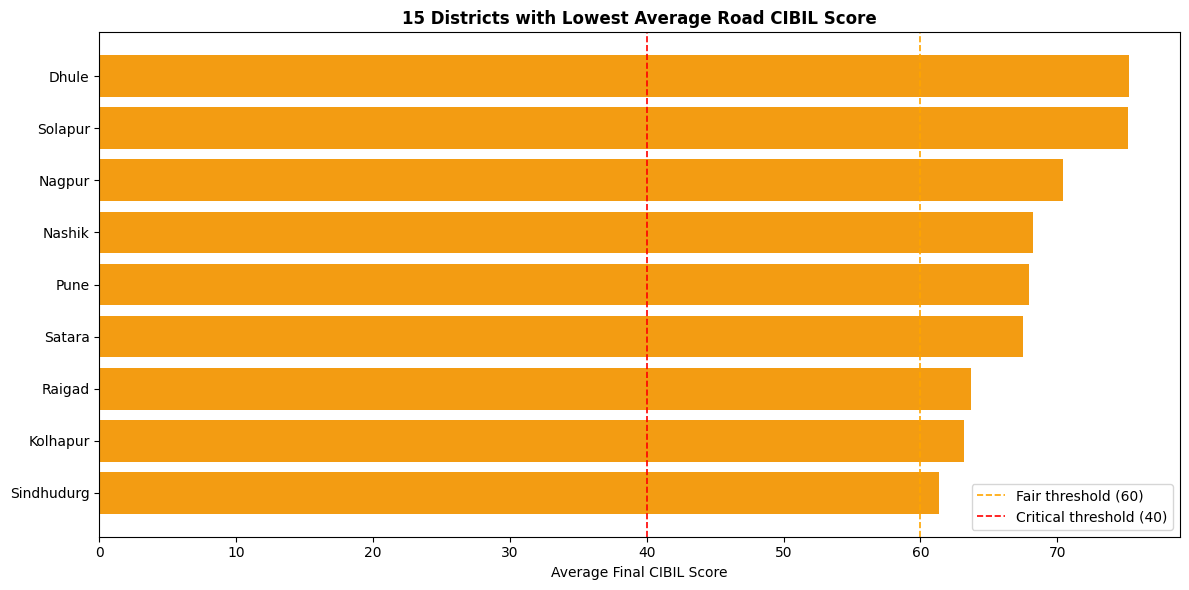


── District-level summary (worst 15) ──


,district,Avg_CIBIL,Min_CIBIL,Segments
0,Sindhudurg,61.329458,19.89,1605
1,Kolhapur,63.188562,17.53,1801
2,Raigad,63.688638,19.15,1747
3,Satara,67.503086,29.85,1740
4,Pune,67.914934,30.54,1972
5,Nashik,68.205845,32.56,1851
6,Nagpur,70.411850,35.03,1838
7,Solapur,75.174801,47.19,1806
8,Dhule,75.207413,43.25,1952


In [13]:

# ── Per-district condition analysis ──────────────────────────────────────────
if "district" in scored_df.columns:
    district_summary = (
        scored_df.groupby("district")["Final_CIBIL"]
        .agg(["mean", "min", "count"])
        .rename(columns={"mean": "Avg_CIBIL", "min": "Min_CIBIL", "count": "Segments"})
        .sort_values("Avg_CIBIL")
        .reset_index()
    )

    # Top 15 worst-average districts
    worst15 = district_summary.head(15)

    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.barh(worst15["district"], worst15["Avg_CIBIL"],
                   color=[COLORS.get(c, "#e67e22") for c in pd.cut(
                       worst15["Avg_CIBIL"],
                       bins=CONDITION_BINS, labels=CONDITION_LABELS,
                       include_lowest=True
                   )])
    ax.set_title("15 Districts with Lowest Average Road CIBIL Score",
                 fontsize=12, fontweight="bold")
    ax.set_xlabel("Average Final CIBIL Score")
    ax.axvline(60, color="orange", linestyle="--", linewidth=1.2, label="Fair threshold (60)")
    ax.axvline(40, color="red",    linestyle="--", linewidth=1.2, label="Critical threshold (40)")
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "worst_districts.png"), dpi=130)
    plt.show()
    
    print("\n── District-level summary (worst 15) ──")
    display(worst15)


## Section 10 — System Summary & Future Extensibility

---

### ✅ Why Pseudo-Labeling is Necessary

The Maharashtra highway dataset contains **no verified ground-truth condition labels**. Traditional supervised learning requires paired (features, label) data — which is absent here.

Pseudo-labeling bridges this gap:

1. **Deterministic PDI formula** encodes decades of pavement engineering knowledge (IRC:37, IS:1498, AASHTO) directly into a score.
2. It transforms an **unsupervised problem into a supervised regression problem** — allowing a RandomForest to learn nonlinear interactions between traffic load, age, environment, and distress.
3. It is **auditable**: every score can be traced back to individual distress components and their weights — a critical requirement for government governance.

> PDI is the "engineering ground truth" until real inspection labels are available.

---

### ✅ Why Hybrid Blending Improves Robustness

| Approach | Strength | Weakness |
|---|---|---|
| Pure PDI (formula only) | Fully transparent, no data needed | Ignores nonlinear effects of traffic age, environment |
| Pure ML (RF only) | Captures complex interactions | Black-box risk; overfits to pseudo-label noise |
| **Hybrid (70/30)** | **Transparent + nonlinear** | **Best of both worlds** |

The 70/30 blend ensures:
- **Engineering transparency**: 70% of the score is explained by distress physics.
- **ML refinement**: 30% captures how age, rainfall, truck load, and slope modify the actual condition beyond what raw distress metrics show.
- **Governance explainability**: Auditors can explain the score without needing ML expertise.

---

### 🔄 How Real Inspection Labels Would Replace Pseudo-Labels

When field inspections or manual ratings are collected:

```python
# Step 1: Replace pseudo-label generation
# Instead of: df["Pseudo_CIBIL"] = compute_pseudo_labels(df)
# Use:         df["CIBIL_Score"] = field_inspection_df["verified_condition_score"]

# Step 2: Retrain with real labels
model.fit(X_train, y_train_verified)

# Step 3: Gradually phase out deterministic component
# Final_CIBIL = 0.4 * PDI_score + 0.6 * ML_Predicted_CIBIL  (as data grows)
# Final_CIBIL = 0.0 * PDI_score + 1.0 * ML_Predicted_CIBIL  (fully supervised)
```

The modular design of this pipeline makes the transition **zero-refactor**: only the label source and blend weights change.

---

### 🚀 How to Extend for 6-Month Degradation Prediction

```python
# Approach: Panel data regression / time-series degradation model

# 1. Collect multi-snapshot data
#    df["snapshot_date"] = "2025-01-01"
#    historical_df = pd.concat([snapshot_jan, snapshot_jul, snapshot_jan_2026])

# 2. Compute degradation rate
#    df_sorted = historical_df.sort_values(["road_id", "snapshot_date"])
#    df_sorted["delta_cibil"] = df_sorted.groupby("road_id")["Final_CIBIL"].diff()
#    df_sorted["months_elapsed"] = ...

# 3. Train a degradation model
#    X_deg = [traffic_stress, road_age, elevation_m, monsoon_rainfall_category, ...]
#    y_deg = delta_cibil_per_6_months
#    deg_model = GradientBoostingRegressor().fit(X_deg, y_deg)

# 4. Predict future score
#    df["Predicted_CIBIL_6m"] = df["Final_CIBIL"] + deg_model.predict(X_current)
```

---

### 🏗️ Future Integration Architecture

```
┌──────────────────────────────────────────────────────────────────────┐
│                  CRCMS — Production Stack                            │
├──────────────────────────────────────────────────────────────────────┤
│                                                                      │
│  road_cibil_scoring.py ──► FastAPI endpoint /score                   │
│         │                  POST { road_id, features }                │
│         │                  Returns: { Final_CIBIL, category }        │
│         │                                                            │
│         ▼                                                            │
│  PostgreSQL (road_scores table)                                      │
│    road_id | snapshot_date | PDI | Final_CIBIL | Condition_Category  │
│         │                                                            │
│         ▼                                                            │
│  Analytics Dashboard (Metabase / Grafana)                            │
│  Real-time Map (Mapbox / Leaflet)                                    │
│  Predictive Maintenance Engine (6-month degradation)                 │
│                                                                      │
└──────────────────────────────────────────────────────────────────────┘
```

In [14]:

# ──────────────────────────────────────────────────────────────────────────────
#  FULL PIPELINE RUNNER  (convenience — executes all phases sequentially)
#  Useful for batch re-scoring when new data arrives.
# ──────────────────────────────────────────────────────────────────────────────

def run_full_pipeline(data_path: str = DATA_PATH) -> dict:
    """
    Execute the complete Road CIBIL Scoring pipeline end-to-end:
      Phase 1 → preprocess_data
      Phase 2 → compute_pseudo_labels
      Phase 3 → train_model
      Phase 4 → plot_feature_importance + run_shap_analysis
      Phase 5 → compute_hybrid_cibil
      Phase 6 → export_results

    Returns a result dict with output_df, metrics, and importance_df.
    """
    print("╔══════════════════════════════════════════════════════════╗")
    print("║   ROAD CIBIL SCORING MODULE — FULL PIPELINE RUN         ║")
    print("╚══════════════════════════════════════════════════════════╝\n")

    # Phase 1
    raw       = pd.read_csv(data_path)
    clean     = preprocess_data(raw.copy())
    feat_cols = get_feature_cols(clean)
    print(f"Phase 1 ✅  {clean.shape[0]:,} rows, {len(feat_cols)} features")

    # Phase 2
    labelled  = compute_pseudo_labels(clean)
    print(f"Phase 2 ✅  PDI mean={labelled['PDI'].mean():.1f}  "
          f"| Pseudo_CIBIL mean={labelled['Pseudo_CIBIL'].mean():.1f}")

    # Phase 3
    mdl, sc, X_t, y_t, y_p = train_model(labelled, feat_cols)
    mets = evaluate_model(y_t, y_p)
    print(f"Phase 3 ✅  MAE={mets['MAE']}  RMSE={mets['RMSE']}  R²={mets['R²']}")

    # Phase 4
    imp_df = plot_feature_importance(mdl, feat_cols, top_n=20)
    print(f"Phase 4 ✅  Top feature: {imp_df.iloc[0]['feature']}")

    # Phase 5
    scored = compute_hybrid_cibil(labelled, mdl, feat_cols)
    dist   = scored["Condition_Category"].value_counts().to_dict()
    print(f"Phase 5 ✅  Final_CIBIL mean={scored['Final_CIBIL'].mean():.1f} | {dist}")

    # Phase 6
    out_df = export_results(scored)
    print(f"Phase 6 ✅  Saved → {OUT_CSV}\n")

    print("╔══════════════════════════════════════════════════════════╗")
    print("║   PIPELINE COMPLETE                                      ║")
    print("╚══════════════════════════════════════════════════════════╝")

    return {"output_df": out_df, "metrics": mets, "importance_df": imp_df,
            "scored_df": scored, "model": mdl}


# ── Uncomment to run the full pipeline in one shot ────────────────────────────
# results = run_full_pipeline()

print("✅  Full pipeline function defined.")
print("   Call  run_full_pipeline()  to re-score the entire dataset in one command.")
print("   Individual phase outputs are already computed above (Sections 1–9).")


✅  Full pipeline function defined.
   Call  run_full_pipeline()  to re-score the entire dataset in one command.
   Individual phase outputs are already computed above (Sections 1–9).


## Section 11 — Export Model Artifact for FastAPI Deployment

In [15]:

# ──────────────────────────────────────────────────────────────────────────────
#  Export the trained pipeline as a single self-contained artifact
#  This pickle is the ONLY file the FastAPI server needs to run inference.
# ──────────────────────────────────────────────────────────────────────────────
import pickle, json, time

MODEL_PKL = os.path.join(BASE_DIR, "road_cibil_model.pkl")

# ── Bundle everything inference needs into one dict ──────────────────────────
artifact = {
    # Core ML objects
    "model"         : model,        # RandomForestRegressor (already fitted)
    "scaler"        : scaler,       # MinMaxScaler (already fitted)
    "feature_cols"  : feature_cols, # ordered list of 33 feature names

    # Configuration (embedded so inference needs no external config)
    "DISTRESS_COLS" : DISTRESS_COLS,
    "DISTRESS_MAX"  : DISTRESS_MAX,
    "PDI_WEIGHTS"   : PDI_WEIGHTS,
    "CONDITION_BINS": CONDITION_BINS,
    "CONDITION_LABELS": CONDITION_LABELS,

    # Weights for hybrid blending
    "PSEUDO_WEIGHT" : 0.7,
    "ML_WEIGHT"     : 0.3,

    # Drop columns list (used by get_feature_cols inside inference)
    "DROP_COLS"     : [
        "geojson_id", "highway_ref", "road_id", "name",
        "start_lat", "start_lon", "end_lat", "end_lon",
        "condition", "status", "state", "district", "taluka",
        "jurisdiction", "category", "oneway", "highway_type",
        "lanes", "maxspeed", "seasonal_variation",
        "year_constructed", "last_major_rehab_year",
        "segment_start_km", "segment_end_km", "segment_number",
        "PDI", "Pseudo_CIBIL", "ML_Predicted_CIBIL",
        "Final_CIBIL", "Condition_Category",
    ],

    # Metadata
    "model_version" : "v1.0",
    "export_date"   : "2026-02-19",
    "trained_on_rows": len(labelled_df),
    "metrics"       : metrics,      # MAE, RMSE, R² from evaluation
}

# ── Persist ──────────────────────────────────────────────────────────────────
with open(MODEL_PKL, "wb") as f:
    pickle.dump(artifact, f, protocol=pickle.HIGHEST_PROTOCOL)

pkl_size_mb = os.path.getsize(MODEL_PKL) / (1024 ** 2)

print("=" * 60)
print("  MODEL ARTIFACT EXPORTED")
print("=" * 60)
print(f"  Path        : {MODEL_PKL}")
print(f"  Size        : {pkl_size_mb:.2f} MB")
print(f"  Version     : {artifact['model_version']}")
print(f"  Trained on  : {artifact['trained_on_rows']:,} segments")
print(f"  Features    : {len(feature_cols)}")
print(f"  MAE / R²    : {metrics['MAE']} / {metrics['R²']}")
print("=" * 60)
print("\n  ✅  road_cibil_model.pkl is ready for FastAPI deployment.")
print("     Load with: pickle.load(open('road_cibil_model.pkl','rb'))")

# ── Quick smoke-test of the exported pickle ──────────────────────────────────
with open(MODEL_PKL, "rb") as f:
    loaded = pickle.load(f)

sample_row = labelled_df[feature_cols].iloc[[0]]
sample_scaled = loaded["scaler"].transform(sample_row)
test_pred = loaded["model"].predict(sample_scaled)[0]
print(f"\n  Smoke-test (segment 0): ML prediction = {test_pred:.2f}  ✅  Pickle is valid.")


  MODEL ARTIFACT EXPORTED
  Path        : /Users/sahilarundhawane/Desktop/AISSM/road_cibil_model.pkl
  Size        : 43.20 MB
  Version     : v1.0
  Trained on  : 16,312 segments
  Features    : 33
  MAE / R²    : 0.34 / 0.9988

  ✅  road_cibil_model.pkl is ready for FastAPI deployment.
     Load with: pickle.load(open('road_cibil_model.pkl','rb'))

  Smoke-test (segment 0): ML prediction = 84.23  ✅  Pickle is valid.
